# Getting started with Task 1

In [79]:
# Load dependencies!
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F

In [80]:
# Let's do some data preprocessing!


# We are loading the normal heart beats
df_ptbd_normal = pd.read_csv("../Datasets/ecg_dataset/ptbdb_normal.csv", header = None)


# We are loading the abnormal heart beats
df_ptbd_abnormal = pd.read_csv("../Datasets/ecg_dataset/ptbdb_abnormal.csv", header = None)

In [81]:
# Let's convert this to a datatype which is easy to work with: Numpy! or Torch Tensors!

# Converting the normal data to numpy
np_ptbd_normal = df_ptbd_normal.to_numpy()

# Converting the abnormal data to numpy
np_ptbd_abnormal = df_ptbd_abnormal.to_numpy()

# Making sure the data in numpy is the same as the data in the pandas dataframe
print(np_ptbd_normal.shape)
print(np_ptbd_abnormal.shape)

(4046, 188)
(10506, 188)


In [82]:
# Now let's take about 10 % of the dataset for testing and another 10% for validation.
# This will be to both the normal and abnormal dataset

# For the normal dataset, testing will be:
np_ptbd_normal_test = np_ptbd_normal[:int(0.2*np_ptbd_normal.shape[0]), :]

# validation will be
np_ptbd_normal_val = np_ptbd_normal[int(0.1*np_ptbd_normal.shape[0])+1:int(0.2*np_ptbd_normal.shape[0]), :]

# Training will be 
np_ptbd_normal_train = np_ptbd_normal[int(0.1*np_ptbd_normal.shape[0])+1:, :]

# Now let' look at them shapes
print('Normal:')
print('Train: ', np_ptbd_normal_train.shape)
print('Test: ', np_ptbd_normal_test.shape)
print('Val: ', np_ptbd_normal_val.shape)

# And we do the same for abnormal!

# Testing data
np_ptbd_abnormal_test = np_ptbd_abnormal[:int(0.2*np_ptbd_abnormal.shape[0]), :]

# Validation data
np_ptbd_abnormal_val = np_ptbd_abnormal[int(0.1*np_ptbd_abnormal.shape[0])+1:int(0.2*np_ptbd_abnormal.shape[0]), :]

# Training will be 
np_ptbd_abnormal_train = np_ptbd_abnormal[int(0.1*np_ptbd_abnormal.shape[0])+1:, :]

# Now let' look at them shapes
print('Abnormal: ')
print('Train: ', np_ptbd_abnormal_train.shape)
print('Test: ', np_ptbd_abnormal_test.shape)
print('Val: ', np_ptbd_abnormal_val.shape)

Normal:
Train:  (3641, 188)
Test:  (809, 188)
Val:  (404, 188)
Abnormal: 
Train:  (9455, 188)
Test:  (2101, 188)
Val:  (1050, 188)


In [83]:
# Now let's combine the data
np_ptbd_train = np.concatenate([np_ptbd_normal_train, np_ptbd_abnormal_train], axis = 0)
np_ptbd_test = np.concatenate([np_ptbd_normal_test, np_ptbd_abnormal_test], axis = 0)
np_ptbd_val = np.concatenate([np_ptbd_normal_train, np_ptbd_abnormal_val], axis = 0)

# Check their shape
print('Total:')
print('Train data:', np_ptbd_train.shape)
print('Test data:', np_ptbd_test.shape)
print('Val data:', np_ptbd_val.shape)

# And randomize!
np.random.shuffle(np_ptbd_train)
np.random.shuffle(np_ptbd_test)
np.random.shuffle(np_ptbd_val)

Total:
Train data: (13096, 188)
Test data: (2910, 188)
Val data: (4691, 188)


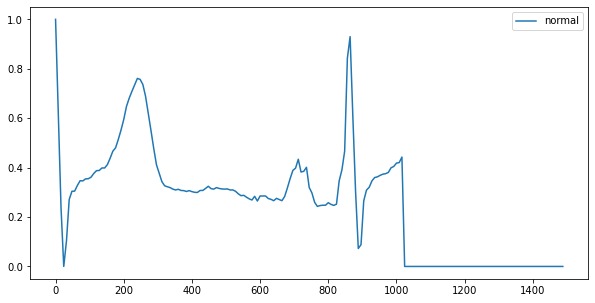

In [84]:
# Let's see if it worked
time = np.arange(np_ptbd_train.shape[1]-1)*1000/125
index = 1
if np_ptbd_train[index,-1] == 1.:
    label = 'abnormal'
else:
    label = 'normal'
    
plt.figure(figsize = (10, 5))
plt.plot(time, np_ptbd_train[index,:-1], label=label)
plt.legend()
plt.show()

# I think it did, no ?

In [85]:
# Now let's separate the data from the labels

# For training
X_np_ptbd_train = np_ptbd_train[:,:-1]
Y_np_ptbd_train = np_ptbd_train[:,-1]


# For testing
X_np_ptbd_test = np_ptbd_test[:,:-1]
Y_np_ptbd_test = np_ptbd_test[:,-1]

# For validation
X_np_ptbd_test = np_ptbd_val[:,:-1]
Y_np_ptbd_test = np_ptbd_val[:,-1]


# Let's load it into Pytorch

# Loading the input data
X_torch_ptbd_train = torch.from_numpy(X_np_ptbd_train)

# Loading the output labels


# But first, we need to convert them to one hot encodings
Y_torch_ptbd_train = torch.from_numpy(Y_np_ptbd_train).type(torch.LongTensor)

# Declare the batch_size for training
batch_size = 32

# And split them into batches
XsplitBatch = list(torch.split(X_torch_ptbd_train, X_torch_ptbd_train.shape[0]//batch_size))
YsplitBatch = list(torch.split(Y_torch_ptbd_train, Y_torch_ptbd_train.shape[0]//batch_size))


# print their shapes
print(Y_torch_ptbd_train.shape)
print(X_torch_ptbd_train.shape)

torch.Size([13096])
torch.Size([13096, 187])


In [102]:
# What if I train a neural network to train on the data

class Network(nn.Module):
    def __init__(self, inpDim, outDim):
        super().__init__()
        self.LinearStack = nn.Sequential(
            nn.Linear(inpDim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 8),
            nn.ReLU(),
            nn.Linear(8, 4),
            nn.ReLU(),
            nn.Linear(4, outDim)
        )
        
    def forward(self, inp):
        return F.log_softmax(self.LinearStack(inp), dim=1)

In [109]:
# Define the model, optimizer, loss function etc

# Define the input_dim
input_dim = np_ptbd_train.shape[1]-1

# Define the output_dim 
output_dim = np_ptbd_train.shape[1]

# Declare the model object
model = Network(inpDim=np_ptbd_train.shape[1]-1, outDim=2)

# Initializing the optimizer
optimizer = optim.Adam(model.parameters(), lr = 1e-4)

# Printing interval
interval = 20

# number of epochs
n_epochs = 100

In [110]:
# Let's train I guess ?
Testing_accuracy = []
for epoch in range(n_epochs):
    print('Epoch: ', epoch+1)
    for i, (x_batch, y_batch) in enumerate(zip(XsplitBatch, YsplitBatch)):
        y_pred = model(x_batch.float())
        loss = F.nll_loss(y_pred, y_batch)
        if i % interval == 0:
            with torch.no_grad():
                y_test_pred = model(torch.from_numpy(X_np_ptbd_test).float())
                test_loss = F.nll_loss(y_test_pred, torch.from_numpy(Y_np_ptbd_test).type(torch.LongTensor), size_average=False).item()
                pred = y_test_pred.data.max(1, keepdim=True)[1]
                correct = (torch.from_numpy(Y_np_ptbd_test).type(torch.LongTensor) == pred.reshape(-1)).sum()
                accuracy = correct/X_np_ptbd_test.shape[0]
                Testing_accuracy.append(accuracy)
                print('Accuracy {}'.format(accuracy))
                print('Test Loss:', test_loss)

            print('Loss: ', loss.item())
            (torch.from_numpy(Y_np_ptbd_test).type(torch.LongTensor) == pred.reshape(-1)).sum()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    
    

Epoch:  1
Accuracy 0.2238328754901886
Test Loss: 3726.184814453125
Loss:  0.6421306729316711
Accuracy 0.2238328754901886
Test Loss: 3767.6416015625
Loss:  0.6340132355690002
Epoch:  2
Accuracy 0.2238328754901886
Test Loss: 3785.373291015625
Loss:  0.637428879737854
Accuracy 0.2238328754901886
Test Loss: 3822.746826171875
Loss:  0.6289893984794617
Epoch:  3
Accuracy 0.2238328754901886
Test Loss: 3852.996337890625
Loss:  0.6311318874359131
Accuracy 0.2238328754901886
Test Loss: 3921.950439453125
Loss:  0.6187868714332581
Epoch:  4
Accuracy 0.2238328754901886
Test Loss: 3958.7578125
Loss:  0.6217585802078247
Accuracy 0.2238328754901886
Test Loss: 3930.7099609375
Loss:  0.6126448512077332
Epoch:  5
Accuracy 0.2238328754901886
Test Loss: 3931.55517578125
Loss:  0.6148984432220459
Accuracy 0.2238328754901886
Test Loss: 3875.457275390625
Loss:  0.6073119044303894
Epoch:  6
Accuracy 0.2238328754901886
Test Loss: 3888.17138671875
Loss:  0.6098806858062744
Accuracy 0.2238328754901886
Test Loss: 

Epoch:  48
Accuracy 0.8610104322433472
Test Loss: 1873.3363037109375
Loss:  0.2442985475063324
Accuracy 0.901939868927002
Test Loss: 1468.94580078125
Loss:  0.18482281267642975
Epoch:  49
Accuracy 0.8635685443878174
Test Loss: 1850.8492431640625
Loss:  0.24140982329845428
Accuracy 0.9040716290473938
Test Loss: 1454.68603515625
Loss:  0.18224215507507324
Epoch:  50
Accuracy 0.8657003045082092
Test Loss: 1831.1929931640625
Loss:  0.23859556019306183
Accuracy 0.9036452770233154
Test Loss: 1438.86328125
Loss:  0.17970985174179077
Epoch:  51
Accuracy 0.8697505593299866
Test Loss: 1797.28515625
Loss:  0.2350333333015442
Accuracy 0.9042847752571106
Test Loss: 1430.3154296875
Loss:  0.1764691025018692
Epoch:  52
Accuracy 0.8769984841346741
Test Loss: 1726.242431640625
Loss:  0.22999778389930725
Accuracy 0.9053506851196289
Test Loss: 1422.1724853515625
Loss:  0.17374052107334137
Epoch:  53
Accuracy 0.8772116899490356
Test Loss: 1714.20263671875
Loss:  0.22745183110237122
Accuracy 0.905990183353

Accuracy 0.9273076057434082
Test Loss: 1122.48388671875
Loss:  0.10610716044902802
Epoch:  95
Accuracy 0.9241099953651428
Test Loss: 1136.9140625
Loss:  0.1453697383403778
Accuracy 0.9275208115577698
Test Loss: 1123.3245849609375
Loss:  0.10498792678117752
Epoch:  96
Accuracy 0.9253890514373779
Test Loss: 1121.365478515625
Loss:  0.1441451758146286
Accuracy 0.9277339577674866
Test Loss: 1118.7982177734375
Loss:  0.10409635305404663
Epoch:  97
Accuracy 0.926668107509613
Test Loss: 1113.1998291015625
Loss:  0.1429697573184967
Accuracy 0.9279471039772034
Test Loss: 1114.2386474609375
Loss:  0.1030537411570549
Epoch:  98
Accuracy 0.9268812537193298
Test Loss: 1101.933349609375
Loss:  0.1420324444770813
Accuracy 0.9277339577674866
Test Loss: 1115.4906005859375
Loss:  0.10221682488918304
Epoch:  99
Accuracy 0.9281603097915649
Test Loss: 1090.33642578125
Loss:  0.14084966480731964
Accuracy 0.9281603097915649
Test Loss: 1104.216064453125
Loss:  0.1013607308268547
Epoch:  100
Accuracy 0.9287998

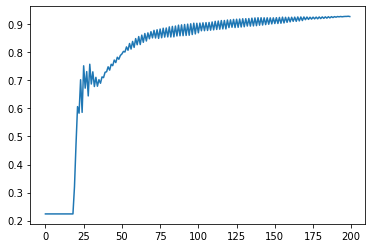

In [111]:
# Let's plot our beautiful results!
plt.plot(Testing_accuracy)